##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Linear Mixed-Effect Regression in {TF Probability, R, Stan}

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/HLM_TFP_R_Stan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/HLM_TFP_R_Stan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## 1  Introduction

In this colab we will fit a linear mixed-effect regression model to a popular, toy dataset.  We will make this fit thrice, using R's `lme4`, Stan's mixed-effects package, and TensorFlow Probability (TFP) primitives.  We conclude by showing all three give roughly the same fitted parameters and posterior distributions. 

Our main conclusion is that TFP has the general pieces necessary to fit HLM-like models and that it produces results which are consistent with other software packages, i.e.., `lme4`, `rstanarm`.  This colab is not an accurate reflection of the computational efficiency of any of the packages compared.

In [0]:
%matplotlib inline

import os
from six.moves import urllib
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize
figsize(11, 9)

import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

## 2  Hierarchical Linear Model


For our comparison between R, Stan, and TFP, we will fit a [Hierarchical Linear Model](https://en.wikipedia.org/wiki/Multilevel_model) (HLM) to the [Radon dataset](http://www.stat.columbia.edu/~gelman/arm/examples/radon/) made popular in [_Bayesian Data Analysis_ by Gelman, et. al.](http://www.stat.columbia.edu/~gelman/book/) (page 559, second ed; page 250, third ed.).


We assume the following generative model:

$$\begin{align*}
\text{for } & c=1\ldots \text{NumCounties}:\\
& \beta_c \sim \text{Normal}\left(\text{loc}=0, \text{scale}=\sigma_C  \right) \\
\text{for } & i=1\ldots \text{NumSamples}:\\
&\eta_i = \underbrace{\omega_0 + \omega_1 \text{Floor}_i}_\text{fixed effects} + \underbrace{\beta_{ \text{County}_i} \log( \text{UraniumPPM}_{\text{County}_i}))}_\text{random effects} \\
&\log(\text{Radon}_i) \sim \text{Normal}(\text{loc}=\eta_i , \text{scale}=\sigma_N)
\end{align*}$$


In R's `lme4` "tilde notation", this model is equivalent to:
> `log_radon ~ 1 + floor +  (0 + log_uranium_ppm | county)`


We will find MLE for $\omega, \sigma_C, \sigma_N$ using the posterior distribution (conditioned on evidence) of $\{\beta_c\}_{c=1}^\text{NumCounties}$.

For essentially the same model but _with_ a random intercept, see _[Appendix A](#scrollTo=tsXhZ4rtNUXL)_.

For a more general specification of HLMs, see _[Appendix B](#scrollTo=H0w7ofFvNsxi)_.

## 3  Data Munging

In this section we obtain the [`radon` dataset](http://www.stat.columbia.edu/~gelman/arm/examples/radon/) and do some minimal preprocessing to make it comply with our assumed model.

In [0]:
# We'll use the following directory to store files we download as well as our
# preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')


def cache_or_download_file(cache_dir, url_base, filename):
  """Read a cached file or download it."""
  filepath = os.path.join(cache_dir, filename)
  if tf.gfile.Exists(filepath):
    return filepath
  if not tf.gfile.Exists(cache_dir):
    tf.gfile.MakeDirs(cache_dir)
  url = os.path.join(url_base, filename)
  print("Downloading {url} to {filepath}.".format(url=url, filepath=filepath))
  urllib.request.urlretrieve(url, filepath)
  return filepath


def download_radon_dataset(cache_dir=CACHE_DIR):
  """Download the radon dataset and read as Pandas dataframe."""
  url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
  # Alternative source:
  # url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/'
  #             'master/reference/data/')
  srrs2 = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'srrs2.dat'))
  srrs2.rename(columns=str.strip, inplace=True)
  cty = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'cty.dat'))
  cty.rename(columns=str.strip, inplace=True)
  return srrs2, cty


def preprocess_radon_dataset(srrs2, cty, state='MN'):
  """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
  srrs2 = srrs2[srrs2.state==state].copy()
  cty = cty[cty.st==state].copy()
  
  # We will now join datasets on Federal Information Processing Standards
  # (FIPS) id, ie, codes that link geographic units, counties and county
  # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
  srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
  cty['fips'] = 1000 * cty.stfips + cty.ctfips

  df = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
  df = df.drop_duplicates(subset='idnum')
  df = df.rename(index=str, columns={'Uppm': 'uranium_ppm'})
  
  # For any missing or invalid activity readings, we'll use a value of `0.1`.
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  
  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = map(str.strip, county_name)
  
  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['uranium_ppm'].apply(np.log) 
  df = df[['log_radon', 'floor', 'county', 'log_uranium_ppm']]
 
  return df, county_name

In [0]:
radon, county_name = preprocess_radon_dataset(*download_radon_dataset())

In [0]:
# Save processed data. (So we can later read it in R.)
with tf.gfile.Open(os.path.join(CACHE_DIR, 'radon.csv'), 'w') as f:
  radon.to_csv(f, index=False)

### 3.1  Know Thy Data

In this section we explore the `radon` dataset to get a better sense of why the proposed model might be reasonable.

In [0]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


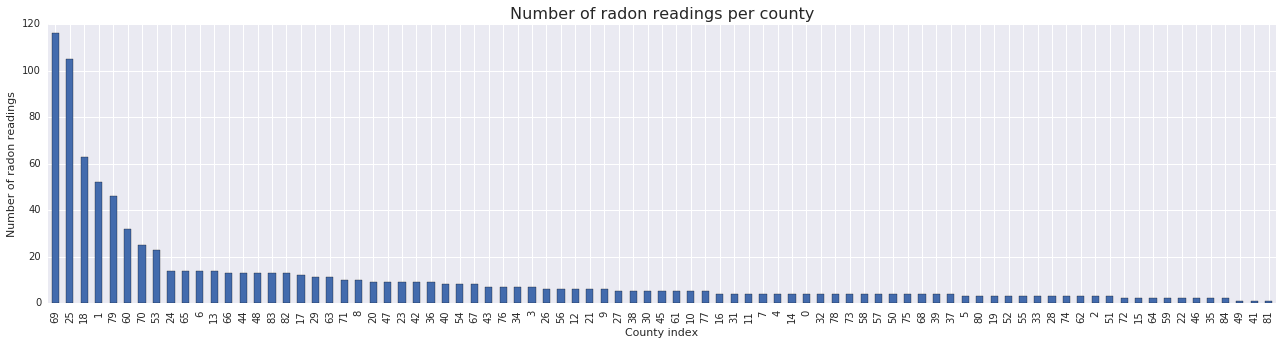

In [0]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = radon['county'].value_counts()
county_freq.plot(kind='bar', color='#436bad');
plt.xlabel('County index')
plt.ylabel('Number of radon readings')
plt.title('Number of radon readings per county', fontsize=16)
county_freq = np.array(zip(county_freq.index, county_freq.values))  # We'll use this later.

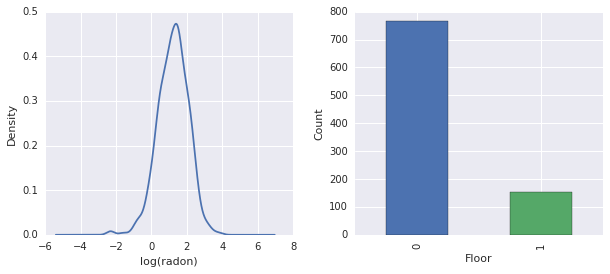

In [0]:
fig, ax = plt.subplots(ncols=2, figsize=[10, 4]);

radon['log_radon'].plot(kind='density', ax=ax[0]);
ax[0].set_xlabel('log(radon)')

radon['floor'].value_counts().plot(kind='bar', ax=ax[1]);
ax[1].set_xlabel('Floor');
ax[1].set_ylabel('Count');

fig.subplots_adjust(wspace=0.25)

Conclusions:
- There's a long tail of 85 counties. (A common occurrence in GLMMs.)
- Indeed $\log(\text{Radon})$ is unconstrained. (So linear regression might make sense.)
- Readings are most made on the $0$-th floor; no reading was made above floor $1$. (So our fixed effects will only have two weights.)


## 4  HLM In R

In this section we use R's [`lme4`](https://cran.r-project.org/web/packages/lme4/index.html) package to fit probabilistic model described above.

**NOTE: To execute this section, you must switch to an `R` colab runtime.**

In [0]:
suppressMessages({
  library('bayesplot')
  library('data.table')
  library('dplyr')
  library('gfile')
  library('ggplot2')
  library('lattice')
  library('lme4')
  library('plyr')
  library('rstanarm')
  library('tidyverse')
  RequireInitGoogle()
})

In [0]:
data = read_csv(gfile('/tmp/radon/radon.csv'))

Parsed with column specification:
cols(
  log_radon = col_double(),
  floor = col_integer(),
  county = col_integer(),
  log_uranium_ppm = col_double()
)


In [0]:
head(data)

# A tibble: 6 x 4
  log_radon floor county log_uranium_ppm
      <dbl> <int>  <int>           <dbl>
1     0.788     1      0          -0.689
2     0.788     0      0          -0.689
3     1.06      0      0          -0.689
4     0         0      0          -0.689
5     1.13      0      1          -0.847
6     0.916     0      1          -0.847

In [0]:
# https://github.com/stan-dev/example-models/wiki/ARM-Models-Sorted-by-Chapter
radon.model <- lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)

In [0]:
summary(radon.model)

Linear mixed model fit by REML ['lmerMod']
Formula: log_radon ~ 1 + floor + (0 + log_uranium_ppm | county)
   Data: data

REML criterion at convergence: 2166.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5202 -0.6064  0.0107  0.6334  3.4111 

Random effects:
 Groups   Name            Variance Std.Dev.
 county   log_uranium_ppm 0.7545   0.8686  
 Residual                 0.5776   0.7600  
Number of obs: 919, groups:  county, 85

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.47585    0.03899   37.85
floor       -0.67974    0.06963   -9.76

Correlation of Fixed Effects:
      (Intr)
floor -0.330

$county


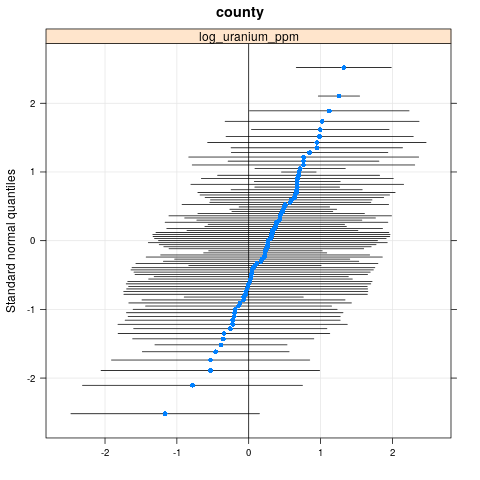

In [0]:
qqmath(ranef(radon.model, condVar=TRUE))

In [0]:
write.csv(as.data.frame(ranef(radon.model, condVar = TRUE)), '/tmp/radon/lme4_fit.csv')

## 5  HLM In Stan


In this section we use [rstanarm](http://mc-stan.org/users/interfaces/rstanarm) to fit a Stan model using the same formula/syntax as the `lme4` model above.

Unlike `lme4` and the TF model below, `rstanarm` is a fully Bayesian model, i.e., all parameters are presumed drawn from a Normal distribution with parameters themselves drawn from a distribution.

**NOTE: To execute this section, you must switch an `R` colab runtime.**

In [0]:
fit <- stan_lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)
 Elapsed Time: 7.73495 seconds (Warm-up)
               2.98852 seconds (Sampling)
               10.7235 seconds (Total)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 

**Note**: The runtimes are from a single CPU core. (This colab is not intended to be a faithful representation of Stan or TFP runtime.)

In [0]:
fit

stan_lmer(formula = log_radon ~ 1 + floor + (0 + log_uranium_ppm | 
    county), data = data)

Estimates:
            Median MAD_SD
(Intercept)  1.5    0.0  
floor       -0.7    0.1  
sigma        0.8    0.0  

Error terms:
 Groups   Name            Std.Dev.
 county   log_uranium_ppm 0.87    
 Residual                 0.76    
Num. levels: county 85 

Sample avg. posterior predictive 
distribution of y (X = xbar):
         Median MAD_SD
mean_PPD 1.2    0.0   

Observations: 919  Number of unconstrained parameters: 90 

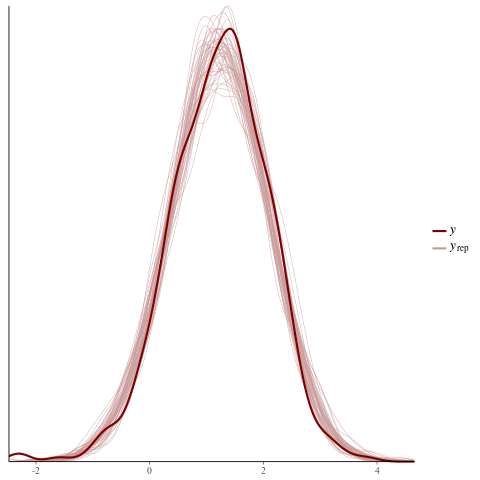

In [0]:
color_scheme_set("red")
ppc_dens_overlay(y = fit$y,
                 yrep = posterior_predict(fit, draws = 50))

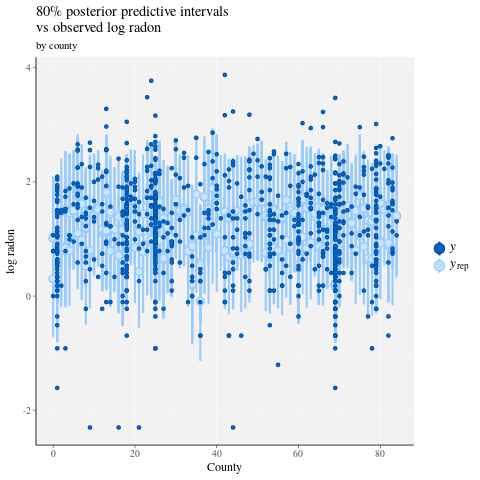

In [0]:
color_scheme_set("brightblue")
ppc_intervals(
  y = data$log_radon,
  yrep = posterior_predict(fit),
  x = data$county,
  prob = 0.8
) +
  labs(
    x = "County",
    y = "log radon",
    title = "80% posterior predictive intervals \nvs observed log radon",
    subtitle = "by county"
  ) +
  panel_bg(fill = "gray95", color = NA) +
  grid_lines(color = "white")

In [0]:
# Write the posterior samples (4000 for each variable) to a CSV.
write.csv(tidy(as.matrix(fit)), "/tmp/radon/stan_fit.csv")

**Note: Switch back to the Python TF kernel runtime.**

In [0]:
with tf.gfile.Open('/tmp/radon/lme4_fit.csv', 'r') as f:
  lme4_fit = pd.read_csv(f, index_col=0)

In [0]:
lme4_fit.head()

,grpvar,term,grp,condval,condsd
1,county,log_uranium_ppm,0,0.667653,0.465584
2,county,log_uranium_ppm,1,0.697805,0.123133
3,county,log_uranium_ppm,2,-0.010856,0.847489
4,county,log_uranium_ppm,3,-0.068872,0.422883
5,county,log_uranium_ppm,4,0.036075,0.825677


Retrieve the point estimates and conditional standard deviations for the group random effects from lme4 for visualization later.

In [0]:
posterior_random_weights_lme4 = np.array(lme4_fit.condval, dtype=np.float32)
lme4_prior_scale = np.array(lme4_fit.condsd, dtype=np.float32)
print(posterior_random_weights_lme4.shape, lme4_prior_scale.shape)

(85,) (85,)


Draw samples for the county weights using the lme4 estimated means and standard deviations.

In [0]:
with tf.Session() as sess:
  lme4_dist = tfp.distributions.Independent(
      tfp.distributions.Normal(
          loc=posterior_random_weights_lme4,
          scale=lme4_prior_scale),
      reinterpreted_batch_ndims=1)
  posterior_random_weights_lme4_final_ = sess.run(lme4_dist.sample(4000))

In [0]:
posterior_random_weights_lme4_final_.shape

(4000, 85)

We also retrieve the posterior samples of the county weights from the Stan fit.

In [0]:
with tf.gfile.Open('/tmp/radon/stan_fit.csv', 'r') as f:
  samples = pd.read_csv(f, index_col=0)

In [0]:
samples.head()

,X.Intercept.,floor,b.log_uranium_ppm.county.0.,b.log_uranium_ppm.county.1.,b.log_uranium_ppm.county.2.,b.log_uranium_ppm.county.3.,b.log_uranium_ppm.county.4.,b.log_uranium_ppm.county.5.,b.log_uranium_ppm.county.6.,b.log_uranium_ppm.county.7.,...,b.log_uranium_ppm.county.76.,b.log_uranium_ppm.county.77.,b.log_uranium_ppm.county.78.,b.log_uranium_ppm.county.79.,b.log_uranium_ppm.county.80.,b.log_uranium_ppm.county.81.,b.log_uranium_ppm.county.82.,b.log_uranium_ppm.county.83.,b.log_uranium_ppm.county.84.,sigma
1,1.450331,-0.757375,1.093099,0.603985,-0.661680,-0.667052,0.549178,-0.150145,1.486173,0.053578,...,0.323107,0.282121,-0.188251,0.889385,1.008348,0.429430,0.404690,0.112424,-0.071612,0.778706
2,1.453383,-0.659085,0.560266,0.580569,0.419441,-0.154925,-1.263534,0.166291,1.534917,1.141392,...,0.306941,0.331696,0.614852,0.153913,1.253688,0.246746,0.849947,-1.399027,-1.697360,0.754960
3,1.460351,-0.804513,1.145694,0.705337,2.216364,-1.044031,1.510397,-0.472675,0.427448,0.940869,...,1.941637,0.188311,-0.690044,0.946370,1.626093,0.930756,0.141125,0.041392,-0.135538,0.763605
4,1.438725,-0.565721,0.204148,0.810580,-1.982466,1.044825,-1.339406,0.643384,2.379191,0.295981,...,-0.832814,0.246694,-0.801078,0.072430,0.108882,-0.203805,0.443365,-0.901578,-0.063022,0.750404
5,1.457569,-0.658910,0.140554,0.593056,-2.618940,0.484812,-0.417834,0.735558,1.693997,0.230496,...,-0.608215,-0.586245,0.204547,0.350195,0.164781,-0.009945,0.023533,-0.177017,-0.425871,0.755898


In [0]:
posterior_random_weights_cols = [
    col for col in samples.columns if 'b.log_uranium_ppm.county' in col
]
posterior_random_weights_final_stan = samples[
    posterior_random_weights_cols].values
print(posterior_random_weights_final_stan.shape)

(4000, 85)


 [This Stan example](https://github.com/stan-dev/example-models/blob/master/ARM/Ch.16/radon.3.stan) shows how one would implement LMER in a style closer to TFP, i.e., by directly specifying the probabilistic model.

## 6  HLM In TF Probability

In this section we will use low-level TensorFlow Probability primitives (`Distributions`) to specify our Hierarchical Linear Model as well as fit the unkown parameters.

In [0]:
# Handy snippet to reset the global graph and global session.
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  tf.reset_default_graph()
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

### 6.1  Specify Model

In this section we specify the [radon linear mixed-effect model](#scrollTo=IFC9r-h0XlQ3) using TFP primitives. To do this, we specify two functions which produce two TFP distributions:
- `make_weights_prior`: A multivariate Normal prior for the random weights (which are multiplied by $\log(\text{UraniumPPM}_{c_i})$ to compue the linear predictor).
- `make_log_radon_likelihood`: A batch of `Normal` distributions over each observed $\log(\text{Radon}_i)$ dependent variable.


Since we will be fitting the parameters of each of these distributions we must use TF variables (i.e., [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable)). However, since we wish to use unconstrained optimzation we must find a way to constrain real-values to achieve the necessary semantics, eg, postives which represent standard deviations. 

In [0]:
inv_scale_transform = lambda y: np.log(y)  # Not using TF here.
fwd_scale_transform = tf.exp

The following function constructs our prior, $p(\beta|\sigma_C)$ where $\beta$ denotes the random-effect weights and $\sigma_C$ the standard deviation.

We use `tf.make_template` to ensure that the first call to this function instantiates the TF variables it uses and all subsequent calls _reuse_ the variable's current value.

In [0]:
def _make_weights_prior(num_counties, dtype):
  """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
  raw_prior_scale = tf.get_variable(
      name='raw_prior_scale',
      initializer=np.array(inv_scale_transform(1.), dtype=dtype))
  return tfp.distributions.Independent(
      tfp.distributions.Normal(
          loc=tf.zeros(num_counties, dtype=dtype),
          scale=fwd_scale_transform(raw_prior_scale)),
      reinterpreted_batch_ndims=1)


make_weights_prior = tf.make_template(
    name_='make_weights_prior', func_=_make_weights_prior)

The following function constructs our likelihood, $p(y|x,\omega,\beta,\sigma_N)$ where $y,x$ denote response and evidence, $\omega,\beta$ denote fixed- and random-effect weights, and $\sigma_N$ the standard deviation.

Here again we use `tf.make_template` to ensure the TF variables are reused across calls.

In [0]:
def _make_log_radon_likelihood(random_effect_weights, floor, county,
                               log_county_uranium_ppm, init_log_radon_stddev):
  raw_likelihood_scale = tf.get_variable(
      name='raw_likelihood_scale',
      initializer=np.array(
          inv_scale_transform(init_log_radon_stddev), dtype=dtype))
  fixed_effect_weights = tf.get_variable(
      name='fixed_effect_weights', initializer=np.array([0., 1.], dtype=dtype))
  fixed_effects = fixed_effect_weights[0] + fixed_effect_weights[1] * floor
  random_effects = tf.gather(
      random_effect_weights * log_county_uranium_ppm,
      indices=tf.to_int32(county),
      axis=-1)
  linear_predictor = fixed_effects + random_effects
  return tfp.distributions.Normal(
      loc=linear_predictor, scale=fwd_scale_transform(raw_likelihood_scale))


make_log_radon_likelihood = tf.make_template(
    name_='make_log_radon_likelihood', func_=_make_log_radon_likelihood)

Finally we use the prior and likelihood generators to construct the joint log-density.

In [0]:
def joint_log_prob(random_effect_weights, log_radon, floor, county,
                   log_county_uranium_ppm, dtype):
  num_counties = len(log_county_uranium_ppm)
  rv_weights = make_weights_prior(num_counties, dtype)
  rv_radon = make_log_radon_likelihood(
      random_effect_weights,
      floor,
      county,
      log_county_uranium_ppm,
      init_log_radon_stddev=radon.log_radon.values.std())
  return (rv_weights.log_prob(random_effect_weights)
          + tf.reduce_sum(rv_radon.log_prob(log_radon), axis=-1))

### 6.2  Training (Stochastic Approximation of Expectation Maximization)

To fit our linear mixed-effect regression model, we will use a stochastic approximation version of the Expectation Maximization algorithm  (SAEM).  The basic idea is to use samples from the posterior to approximate the expected joint log-density (E-step). Then we find the parameters which maximize this calculation (M-step). Somewhat more concretely, the fixed-point iteration is given by:

$$\begin{align*}
\text{E}[ \log p(x, Z | \theta) | \theta_0]
&\approx \frac{1}{M} \sum_{m=1}^M \log p(x, z_m | \theta), \quad Z_m\sim p(Z | x, \theta_0) && \text{E-step}\\
&=: Q_M(\theta, \theta_0) \\
\theta_0 &= \theta_0 - \eta \left.\nabla_\theta Q_M(\theta, \theta_0)\right|_{\theta=\theta_0} && \text{M-step}
\end{align*}$$

where $x$ denotes evidence, $Z$ some latent variable which needs to be marginalized out, and $\theta,\theta_0$ possible parameterizations.

For a more thorough explanation, see [_Convergence of a stochastic approximation version of the EM algorithms_ by Bernard Delyon, Marc Lavielle, Eric, Moulines (Ann. Statist., 1999)](https://projecteuclid.org/euclid.aos/1018031103).

To compute the E-step, we need to sample from the posterior. Since our posterior is not easy to sample from, we use Hamiltonian Monte Carlo (HMC). HMC is a Monte Carlo Markov Chain procedure which uses gradients (wrt state, not parameters) of the unnormalized posterior log-density to propose new samples.


Specifying the unnormalized posterior log-density is simple--it is merely the joint log-density "pinned" at whatever we wish to condition on.

In [0]:
# Specify unnormalized posterior.

dtype = np.float32

log_county_uranium_ppm = radon[
    ['county', 'log_uranium_ppm']].drop_duplicates().values[:, 1]
log_county_uranium_ppm = log_county_uranium_ppm.astype(dtype)

def unnormalized_posterior_log_prob(random_effect_weights):
  return joint_log_prob(
      random_effect_weights=random_effect_weights,
      log_radon=dtype(radon.log_radon.values),
      floor=dtype(radon.floor.values),
      county=np.int32(radon.county.values),
      log_county_uranium_ppm=log_county_uranium_ppm,
      dtype=dtype)

We now complete the E-step setup by creating an HMC transition kernel. 

Notes:

- We use `state_stop_gradient=True`to prevent the M-step from backpropping through draws from the MCMC. (Recall, we needn't backprop through because our E-step is intentionally parameterized at the _previous_ best known estimators.)

- We use [`tf.placeholder`](https://www.tensorflow.org/api_docs/python/tf/placeholder) so that when we eventually execute our TF graph, we can feed the previous iteration's random MCMC sample as the the next iteration's chain's value.

- We use TFP's adaptive `step_size` heuristic, `tfp.mcmc.hmc_step_size_update_fn`.

In [0]:
# Set-up E-step.

step_size = tf.get_variable(
    'step_size',
    initializer=np.array(0.2, dtype=dtype),
    trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior_log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=None),
    state_gradients_are_stopped=True)

init_random_weights = tf.placeholder(dtype, shape=[len(log_county_uranium_ppm)])

posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
    num_results=3,
    num_burnin_steps=0,
    num_steps_between_results=0,
    current_state=init_random_weights,
    kernel=hmc)

We now set-up the M-step. This is essentially the same as an optimization one might do in TF.

In [0]:
# Set-up M-step.

loss = -tf.reduce_mean(kernel_results.accepted_results.target_log_prob)

global_step = tf.train.get_or_create_global_step()

learning_rate = tf.train.exponential_decay(
    learning_rate=0.1,
    global_step=global_step,
    decay_steps=2,
    decay_rate=0.99)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

We conclude with some housekeeping tasks. We must tell TF that all variables are initialized. We also create handles to our TF variables so we can `print` their values at each iteration of the procedure. 

In [0]:
# Initialize all variables.

init_op = tf.initialize_all_variables()

In [0]:
# Grab variable handles for diagnostic purposes.

with tf.variable_scope('make_weights_prior', reuse=True):
  prior_scale = fwd_scale_transform(tf.get_variable(
      name='raw_prior_scale', dtype=dtype))
  
with tf.variable_scope('make_log_radon_likelihood', reuse=True):
  likelihood_scale = fwd_scale_transform(tf.get_variable(
      name='raw_likelihood_scale', dtype=dtype))
  fixed_effect_weights = tf.get_variable(
      name='fixed_effect_weights', dtype=dtype)

### 6.3  Execute

In this section we execute our SAEM TF graph.  The main trick here is to feed our last draw from the HMC kernel into the next iteration. This is achieved through our use of `feed_dict` in the `sess.run` call.

In [0]:
init_op.run()
w_ = np.zeros([len(log_county_uranium_ppm)], dtype=dtype)

In [0]:
%%time
maxiter = int(1500)
num_accepted = 0
num_drawn = 0
for i in range(maxiter):
  [
      _,
      global_step_,
      loss_,
      posterior_random_weights_,
      kernel_results_,
      step_size_,
      prior_scale_,
      likelihood_scale_,
      fixed_effect_weights_,
  ] = sess.run([
      train_op,
      global_step,
      loss,
      posterior_random_weights,
      kernel_results,
      step_size,
      prior_scale,
      likelihood_scale,
      fixed_effect_weights,
  ], feed_dict={init_random_weights: w_})
  w_ = posterior_random_weights_[-1, :]
  num_accepted += kernel_results_.is_accepted.sum()
  num_drawn += kernel_results_.is_accepted.size
  acceptance_rate = num_accepted / num_drawn
  if i % 100 == 0 or i == maxiter - 1:
    print('global_step:{:>4}  loss:{: 9.3f}  acceptance:{:.4f}  '
          'step_size:{:.4f}  prior_scale:{:.4f}  likelihood_scale:{:.4f}  '
          'fixed_effect_weights:{}'.format(
              global_step_, loss_.mean(), acceptance_rate, step_size_,
              prior_scale_, likelihood_scale_, fixed_effect_weights_))              

global_step:   0  loss: 1966.948  acceptance:1.0000  step_size:0.2000  prior_scale:1.0000  likelihood_scale:0.8529  fixed_effect_weights:[ 0.  1.]
global_step: 100  loss: 1165.385  acceptance:0.6205  step_size:0.2040  prior_scale:0.9568  likelihood_scale:0.7611  fixed_effect_weights:[ 1.47523439 -0.66043079]
global_step: 200  loss: 1149.851  acceptance:0.6766  step_size:0.2081  prior_scale:0.7465  likelihood_scale:0.7665  fixed_effect_weights:[ 1.48918796 -0.67058587]
global_step: 300  loss: 1163.464  acceptance:0.6811  step_size:0.2040  prior_scale:0.8445  likelihood_scale:0.7594  fixed_effect_weights:[ 1.46291411 -0.67586178]
global_step: 400  loss: 1158.846  acceptance:0.6808  step_size:0.2081  prior_scale:0.8377  likelihood_scale:0.7574  fixed_effect_weights:[ 1.47349834 -0.68823022]
global_step: 500  loss: 1154.193  acceptance:0.6766  step_size:0.1961  prior_scale:0.8546  likelihood_scale:0.7564  fixed_effect_weights:[ 1.47703862 -0.67521363]
global_step: 600  loss: 1163.903  acce

Looks like after ~1500 steps, our estimates of the parameters have stabilized.

### 6.4  Results

Now that we've fit the parameters, let's generate a large number of posterior samples and study the results.

In [0]:
%%time
posterior_random_weights_final, kernel_results_final = tfp.mcmc.sample_chain(
    num_results=int(15e3),
    num_burnin_steps=int(1e3),
    current_state=init_random_weights,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_posterior_log_prob,
      num_leapfrog_steps=2,
      step_size=step_size))

[
    posterior_random_weights_final_,
    kernel_results_final_,
] = sess.run([
    posterior_random_weights_final,
    kernel_results_final,
], feed_dict={init_random_weights: w_})

CPU times: user 1min 42s, sys: 26.6 s, total: 2min 8s
Wall time: 35.1 s


In [0]:
print('prior_scale: ', prior_scale_)
print('likelihood_scale: ', likelihood_scale_)
print('fixed_effect_weights: ', fixed_effect_weights_)
print('acceptance rate final: ', kernel_results_final_.is_accepted.mean())

prior_scale:  0.873799
likelihood_scale:  0.758913
fixed_effect_weights:  [ 1.47624075 -0.67875224]
acceptance rate final:  0.7448


We now construct a box and whisker diagram of the $\beta_c \log(\text{UraniumPPM}_c)$ random-effect. We'll order the random-effects by decreasing county frequency.

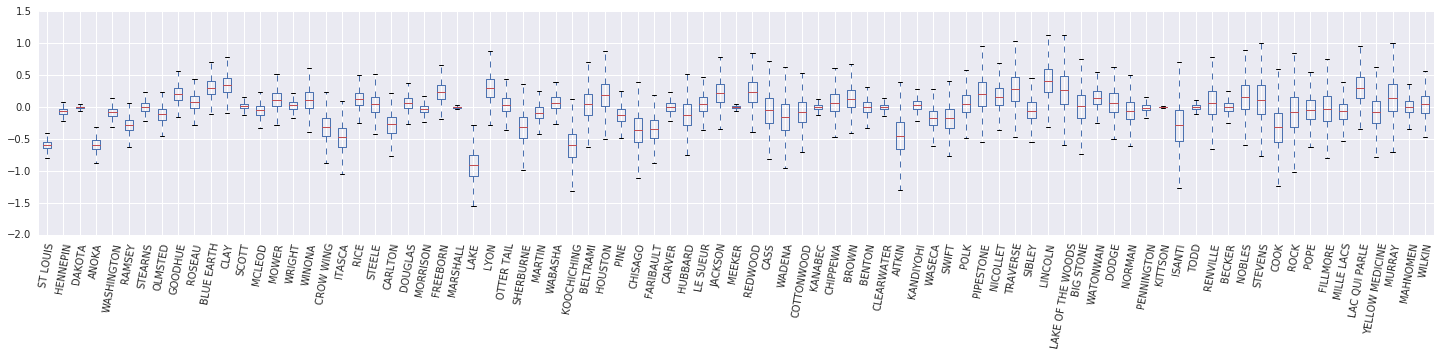

In [0]:
x = posterior_random_weights_final_ * log_county_uranium_ppm
I = county_freq[:, 0]
x = x[:, I]
cols = np.array(county_name)[I]
pw = pd.DataFrame(x)
pw.columns = cols

fig, ax = plt.subplots(figsize=(25, 4))
ax = pw.boxplot(rot=80, vert=True);

From this box and whisker diagram, we observe that the variance of the county-level $\log(\text{UraniumPPM})$ random-effect increases as the county is less represented in the dataset. Intutively this makes sense--we should be less certain about the impact of a certain county if we have less evidence for it.

## 7 Side-by-Side-by-Side Comparison

We now compare the results of all three procedures. To do this, we will compute non-parameteric estimates of the posterior samples as generated by Stan and TFP. We will also compare against the parameteric (approximate) estimates produced by R's `lme4` package.

The following plot depicts the posterior distribution of each weight for each county in Minnesota. We show results for Stan (red), TFP (blue), and R's `lme4` (orange).  We shade results from Stan and TFP thus expect to see purple when the two agree. For simplicity we do not shade results from R.  Each subplot represents a single county and are ordered in descending frequency in raster scan order (i.e., from left-to-right then top-to-bottom).

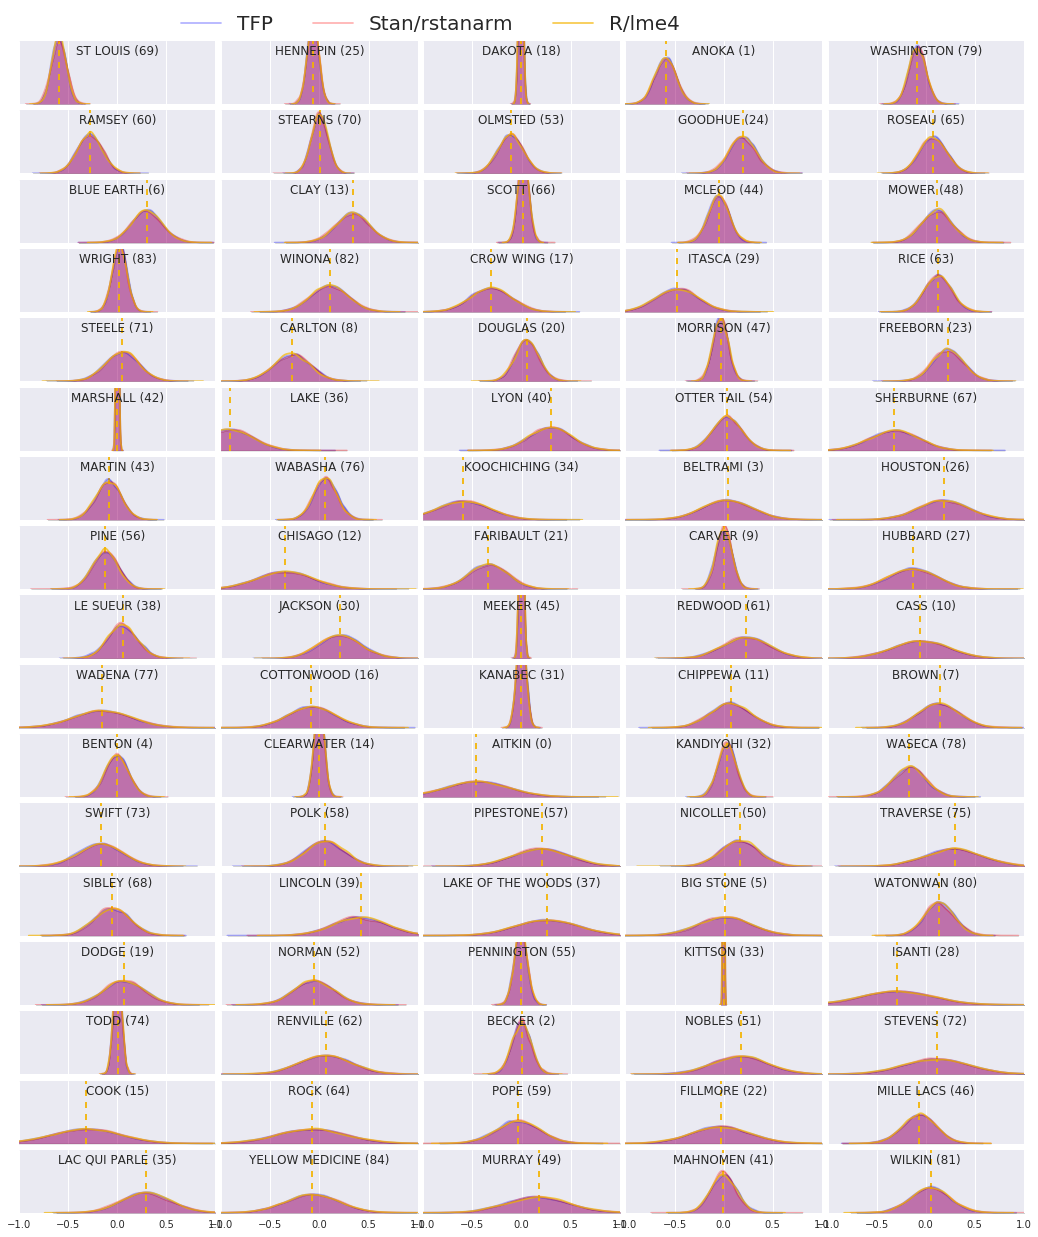

In [0]:
nrows = 17
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 21), sharey=True, sharex=True)
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  ii = -1
  for r in range(nrows):
    for c in range(ncols):
      ii += 1
      idx = county_freq[ii, 0]
      sns.kdeplot(
          posterior_random_weights_final_[:, idx] * log_county_uranium_ppm[idx],
          color='blue',
          alpha=.3,
          shade=True,
          label='TFP',
          ax=ax[r][c])
      sns.kdeplot(
          posterior_random_weights_final_stan[:, idx] *
          log_county_uranium_ppm[idx],
          color='red',
          alpha=.3,
          shade=True,
          label='Stan/rstanarm',
          ax=ax[r][c])
      sns.kdeplot(
          posterior_random_weights_lme4_final_[:, idx] *
          log_county_uranium_ppm[idx],
          color='#F4B400',
          alpha=.7,
          shade=False,
          label='R/lme4',
          ax=ax[r][c])
      ax[r][c].vlines(
          posterior_random_weights_lme4[idx] * log_county_uranium_ppm[idx],
          0,
          5,
          color='#F4B400',
          linestyle='--')
      ax[r][c].set_title(county_name[idx] + ' ({})'.format(idx), y=.7)
      ax[r][c].set_ylim(0, 5)
      ax[r][c].set_xlim(-1., 1.)
      ax[r][c].get_yaxis().set_visible(False)
      if ii == 2:
        ax[r][c].legend(bbox_to_anchor=(1.4, 1.7), fontsize=20, ncol=3)
      else:
        ax[r][c].legend_.remove()
  fig.subplots_adjust(wspace=0.03, hspace=0.1)

## 8  Conclusion

In this colab we fit a linear mixed-effect regression model to the radon dataset. We tried three different software packages: R, Stan, and TensorFlow Probability. We concluded by plotting the 85 posterior distributions as computed by the three different software packages. 

## Appendix A:  Alternative Radon HLM (Add Random Intercept)

In this section we describe an alternative HLM which also has a random intercept associated with each county.

$$\begin{align*}
\text{for } & c=1\ldots \text{NumCounties}:\\
& \beta_c \sim \text{MultivariateNormal}\left(\text{loc}=\left[ \begin{array}{c} 0 \\ 0 \end{array}\right] , \text{scale}=\left[\begin{array}{cc} \sigma_{11}  & 0 \\ \sigma_{12} & \sigma_{22} \end{array}\right] \right) \\
\text{for } & i=1\ldots \text{NumSamples}:\\
& c_i := \text{County}_i \\
&\eta_i = \underbrace{\omega_0 + \omega_1\text{Floor}_i \vphantom{\log( \text{CountyUraniumPPM}_{c_i}))}}_{\text{fixed effects}}  + \underbrace{\beta_{c_i,0} + \beta_{c_i,1}\log( \text{CountyUraniumPPM}_{c_i}))}_{\text{random effects}} \\
&\log(\text{Radon}_i) \sim \text{Normal}(\text{loc}=\eta_i , \text{scale}=\sigma)
\end{align*}$$


 In R's `lme4` "tilde notation", this model is equivalent to:
 > `log_radon ~ 1 + floor + (1 + log_county_uranium_ppm | county)`

## Appendix B:  Generalized Linear Mixed-Effect Models

In this section we give a more general characterization of Hierarchical Linear Models than what is used in the main body. This more general model is known as a [generalized linear mixed-effect model](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model) (GLMM).


GLMMs are generalizations of [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLMs). GLMMs extend GLMs by incorporating sample specific random noise into the predicted linear response.  This is useful in part because it allows rarely seen features to share information with more commonly seen features.


As a generative process, a Generalized Linear Mixed-effects Model (GLMM) is characterized by:

\begin{align}
\text{for } & r = 1\ldots R:  \hspace{2.45cm}\text{# for each random-effect group}\\
 &\begin{aligned}
  \text{for } &c = 1\ldots |C_r|:  \hspace{1.3cm}\text{# for each category ("level") of group $r$}\\
  &\begin{aligned}
    \beta_{rc}
    &\sim \text{MultivariateNormal}(\text{loc}=0_{D_r}, \text{scale}=\Sigma_r^{1/2})
  \end{aligned}
\end{aligned}\\\\
\text{for } & i = 1 \ldots N:  \hspace{2.45cm}\text{# for each sample}\\
&\begin{aligned}
  &\eta_i = \underbrace{\vphantom{\sum_{r=1}^R}x_i^\top\omega}_\text{fixed effects} + \underbrace{\sum_{r=1}^R z_{r,i}^\top \beta_{r,C_r(i) }}_\text{random effects} \\
  &Y_i|x_i,\omega,\{z_{r,i} , \beta_r\}_{r=1}^R \sim \text{Distribution}(\text{mean}= g^{-1}(\eta_i))
\end{aligned}
\end{align}


where:

\begin{align}
R &= \text{number of random-effect groups}\\
|C_r| &= \text{number of categories for group $r$}\\
N &= \text{number of training samples}\\
x_i,\omega &\in \mathbb{R}^{D_0}\\
D_0 &= \text{number of fixed-effects}\\
C_r(i) &= \text{category (under group $r$) of the $i$th sample}\\
z_{r,i} &\in \mathbb{R}^{D_r}\\
D_r &= \text{number of random-effects associated with group $r$}\\
\Sigma_{r} &\in \{S\in\mathbb{R}^{D_r \times D_r} : S \succ 0 \}\\
\eta_i\mapsto g^{-1}(\eta_i) &= \mu_i, \text{inverse link function}\\
\text{Distribution} &=\text{some distribution parameterizable solely by its mean}
\end{align}


In words, this says that every category of each group is associated with an iid MVN, $\beta_{rc}$. Although the $\beta_{rc}$ draws are always independent, they are only indentically distributed for a group $r$; notice there is exactly one $\Sigma_r$ for each $r\in\{1,\ldots,R\}$.

When affinely combined with a sample's group's features, $z_{r,i}$, the result is sample-specific noise on the $i$-th predicted linear response (which is otherwise $x_i^\top\omega$).


When we estimate $\{\Sigma_r:r\in\{1,\ldots,R\}\}$ we're essentially estimating the amount of noise a random-effect group carries which would otherwise drown out the signal present in $x_i^\top\omega$.

There are a variety of options for the $\text{Distribution}$ and [inverse link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function), $g^{-1}$. Common choices are:
- $Y_i\sim\text{Normal}(\text{mean}=\eta_i, \text{scale}=\sigma)$,
- $Y_i\sim\text{Binomial}(\text{mean}=n_i \cdot \text{sigmoid}(\eta_i), \text{total_count}=n_i)$, and, 
- $Y_i\sim\text{Poisson}(\text{mean}=\exp(\eta_i))$.

For more possibilities, see the [`tfp.glm`](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/glm) module.